In [1]:
import gym
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import random

In [2]:
class DQN():
    def __init__(self, state_dim, action_n, batch_size, gamma, lr, trajectory_n):
        self.action_n = action_n
        self.epsilon = 1
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_n)
        )
        self.epsilon_decrease = 1 / trajectory_n
        self.memory = []
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def get_action(self, state):
        qvalues = self.model(torch.FloatTensor(state)).detach().numpy()
        prob = np.ones(self.action_n) * self.epsilon / self.action_n
        argmax_action = np.argmax(qvalues)
        prob[argmax_action] += 1 - self.epsilon
        action = np.random.choice(np.arange(self.action_n), p=prob)
        return action

    def get_batch(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, dones, next_states = [], [], [], [], []
        for i in range(len(batch)):
            states.append(batch[i][0])
            actions.append(batch[i][1])
            rewards.append(batch[i][2])
            dones.append(batch[i][3])
            next_states.append(batch[i][4])
        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        return states, actions, rewards, dones, next_states

    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, done, next_state])

        if len(self.memory) > self.batch_size:
            states, actions, rewards, dones, next_states = self.get_batch()

            qvalues = self.model(states)
            next_qvalues = self.model(next_states)

            targets = qvalues.clone()
            for i in range(self.batch_size):
                targets[i][actions[i]] = rewards[i] + (1 - dones[i]) * self.gamma * torch.max(next_qvalues[i])

            loss = torch.mean((targets.detach() - qvalues) ** 2)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            self.epsilon = max(0, self.epsilon - self.epsilon_decrease)

In [3]:
import os

import torch
import gym
import pandas as pd
from torch import nn
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt



class CEM(nn.Module):
    def __init__(self, state_dim, action_n, q_param):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        self.q_param = q_param

        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_n)
        )

        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        action_prob = self.softmax(logits).detach().numpy()
        action = np.random.choice(self.action_n, p=action_prob)
        return action

    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)

        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()


def fit(agent, episode_n, trajectory_n, trajectory_len):
    total_rewards = []
    for episode in range(episode_n):
        trajectories = [get_trajectory(agent, trajectory_len) for _ in
                        range(trajectory_n)]

        mean_total_reward = np.mean(
            [trajectory['total_reward'] for trajectory in trajectories])
        total_rewards.append(mean_total_reward)

        elite_trajectories = get_elite_trajectories(trajectories, agent.q_param)

        if len(elite_trajectories) > 0:
            agent.update_policy(elite_trajectories)
    return total_rewards


def get_scores(env, agent, trajectory_len, trajectory_n, filename):
    get_trajectory(env, agent, trajectory_len, visualize=True, filename=filename)
    trajectories = [get_trajectory(env, agent, trajectory_len) for _ in range(trajectory_n)]
    return np.mean([trajectory['total_reward'] for trajectory in trajectories])


def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)


def get_trajectory(agent, trajectory_len, visualize=False, filename=''):
    trajectory = {'states': [], 'actions': [], 'total_reward': 0}

    frames = []
    state = env.reset()
    trajectory['states'].append(state)

    for _ in range(trajectory_len):

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

        trajectory['states'].append(state)

    if visualize:
        save_frames_as_gif(frames, filename=filename)
    return trajectory


def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)
    return [trajectory for trajectory in trajectories if
            trajectory['total_reward'] > quantile]

In [5]:
env = gym.make('Acrobot-v1')
state_dim = env.observation_space.shape[0]
action_n = env.action_space.n

C:\Users\marka\anaconda3\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\marka\anaconda3\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
def train_dcem(qparam=0.3, episode_n=50, trajectory_n=50, trajectory_len=500):
    agent = CEM(state_dim, action_n, q_param=qparam)
    result = fit(agent,
                 episode_n=episode_n,
                 trajectory_n=trajectory_n,
                 trajectory_len=trajectory_len)
    return result

In [7]:
def train_dqn(trajectory_n=50, trajectory_len=500, batch_size=64, gamma=0.99, lr=1e-2):
#     model = NN(state_dim, action_n)
    agent = DQN(state_dim, action_n, batch_size, gamma, lr, trajectory_n)

    result = []
    for trajectory_i in range(trajectory_n):
        total_rewards = 0

        state = env.reset()
        for i in range(trajectory_len):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)

            total_rewards += reward

            agent.fit(state, action, reward, done, next_state)

            state = next_state

            if done:
                break

        result.append(total_rewards)
    return result


C:\Users\marka\AppData\Local\Temp/ipykernel_27616/3283792573.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = self.softmax(logits).detach().numpy()
C:\Users\marka\AppData\Local\Temp/ipykernel_27616/3283792573.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  elite_states = torch.FloatTensor(elite_states)


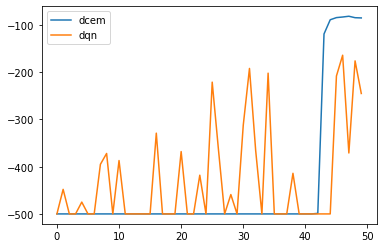

In [8]:
plt.plot(train_dcem(), label='dcem')
plt.plot(train_dqn(batch_size=24), label='dqn')
plt.legend()

In [8]:
def find_best_model(model_type):
    env = gym.make('Acrobot-v1')
    state_dim = env.observation_space.shape[0]
    action_n = env.action_space.n
    
    N_EXPERIMENTS = 10
    
    params = {
        "q_param": [0.3,0.4, 0.5, 0.5, 0.7],
        "episode_n": [50],
        "trajectory_n": [50],
        "trajectory_len": [500, 1000, 2000, 10 ** 4],
        "lr": [1e-2, 1e-3, 1e-4],
        "gamma": [0.8, 0.9, 0.95, 0.99, 0.99],
        "batch_size": [4, 8, 16]
    }
    
    experiments = []
    experiments_result = []
    for i in tqdm(range(N_EXPERIMENTS)):
        exp = {}
        for key in params:
            exp[key] = np.random.choice(params[key])
        print('Experiment', i, exp)
        experiments.append(exp)
    
        if model_type == 'dqn':
            result = train_dqn(
                trajectory_n=exp['trajectory_n'],
                trajectory_len=exp['trajectory_len'],
                batch_size=exp['batch_size'],
                gamma=exp['gamma'],
                lr=exp['lr']
            )
        if model_type == 'dcem':
            result = train_dcem(
                qparam=exp['q_param'],
                episode_n=exp['episode_n'],
                trajectory_n=exp['trajectory_n'],
                trajectory_len=exp['trajectory_len']
            )
        experiments_result.append(result)
    return experiments, experiments_result

In [10]:
print('dqn')
dqn_exp, dqn_result = find_best_model('dqn')
print('dcem')
dcem_exp, dcem_result = find_best_model('dcem')

dqn


  0%|                                                                                                              | 0/10 [00:00<?, ?it/s]

Experiment 0 {'q_param': 0.5, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 1000, 'lr': 0.0001, 'gamma': 0.99, 'batch_size': 256}


 10%|██████████▏                                                                                           | 1/10 [01:35<14:16, 95.18s/it]

Experiment 1 {'q_param': 0.5, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 2000, 'lr': 0.01, 'gamma': 0.8, 'batch_size': 128}


 20%|████████████████████▏                                                                                | 2/10 [03:24<13:46, 103.27s/it]

Experiment 2 {'q_param': 0.3, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 10000, 'lr': 0.001, 'gamma': 0.99, 'batch_size': 256}


 30%|██████████████████████████████▎                                                                      | 3/10 [05:30<13:18, 114.04s/it]

Experiment 3 {'q_param': 0.3, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 2000, 'lr': 0.01, 'gamma': 0.95, 'batch_size': 256}


 40%|████████████████████████████████████████▍                                                            | 4/10 [07:02<10:31, 105.30s/it]

Experiment 4 {'q_param': 0.5, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 1000, 'lr': 0.01, 'gamma': 0.8, 'batch_size': 64}


 50%|███████████████████████████████████████████████████                                                   | 5/10 [07:50<07:01, 84.33s/it]

Experiment 5 {'q_param': 0.4, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 500, 'lr': 0.01, 'gamma': 0.9, 'batch_size': 128}


 60%|█████████████████████████████████████████████████████████████▏                                        | 6/10 [09:40<06:12, 93.15s/it]

Experiment 6 {'q_param': 0.4, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 2000, 'lr': 0.001, 'gamma': 0.99, 'batch_size': 128}


 70%|███████████████████████████████████████████████████████████████████████▍                              | 7/10 [10:53<04:20, 86.71s/it]

Experiment 7 {'q_param': 0.4, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 2000, 'lr': 0.0001, 'gamma': 0.8, 'batch_size': 128}


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 8/10 [12:50<03:12, 96.19s/it]

Experiment 8 {'q_param': 0.5, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 500, 'lr': 0.0001, 'gamma': 0.8, 'batch_size': 256}


 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 9/10 [17:13<02:28, 148.39s/it]

Experiment 9 {'q_param': 0.7, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 500, 'lr': 0.0001, 'gamma': 0.99, 'batch_size': 256}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [19:06<00:00, 114.65s/it]


dcem


  0%|                                                                                                              | 0/10 [00:00<?, ?it/s]/var/folders/nj/kkhdpmks2fj8_3rtb4rd3j_h0000gq/T/ipykernel_67912/3283792573.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = self.softmax(logits).detach().numpy()


Experiment 0 {'q_param': 0.4, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 10000, 'lr': 0.0001, 'gamma': 0.8, 'batch_size': 64}


 10%|██████████                                                                                           | 1/10 [06:25<57:47, 385.33s/it]

Experiment 1 {'q_param': 0.7, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 500, 'lr': 0.0001, 'gamma': 0.8, 'batch_size': 128}


 20%|████████████████████▏                                                                                | 2/10 [07:42<27:10, 203.86s/it]

Experiment 2 {'q_param': 0.7, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 2000, 'lr': 0.01, 'gamma': 0.8, 'batch_size': 128}


 30%|██████████████████████████████▎                                                                      | 3/10 [08:54<16:45, 143.60s/it]

Experiment 3 {'q_param': 0.7, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 10000, 'lr': 0.001, 'gamma': 0.99, 'batch_size': 128}


 40%|████████████████████████████████████████▍                                                            | 4/10 [10:09<11:39, 116.64s/it]

Experiment 4 {'q_param': 0.5, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 1000, 'lr': 0.0001, 'gamma': 0.8, 'batch_size': 256}


 50%|██████████████████████████████████████████████████▌                                                  | 5/10 [12:51<11:05, 133.19s/it]

Experiment 5 {'q_param': 0.5, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 2000, 'lr': 0.01, 'gamma': 0.99, 'batch_size': 64}


 60%|████████████████████████████████████████████████████████████▌                                        | 6/10 [14:34<08:11, 122.84s/it]

Experiment 6 {'q_param': 0.5, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 2000, 'lr': 0.01, 'gamma': 0.8, 'batch_size': 128}


 70%|██████████████████████████████████████████████████████████████████████▋                              | 7/10 [16:15<05:46, 115.62s/it]

Experiment 7 {'q_param': 0.7, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 500, 'lr': 0.01, 'gamma': 0.99, 'batch_size': 64}


 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 8/10 [22:42<06:43, 201.89s/it]

Experiment 8 {'q_param': 0.7, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 500, 'lr': 0.001, 'gamma': 0.99, 'batch_size': 256}


 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 9/10 [24:00<02:43, 163.39s/it]

Experiment 9 {'q_param': 0.3, 'episode_n': 50, 'trajectory_n': 50, 'trajectory_len': 500, 'lr': 0.0001, 'gamma': 0.9, 'batch_size': 64}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [26:20<00:00, 158.02s/it]


In [17]:
dqn_result = np.array(dqn_result)
dcem_result = np.array(dcem_result)

len(dqn_exp), len(dcem_exp)

(10, 10)

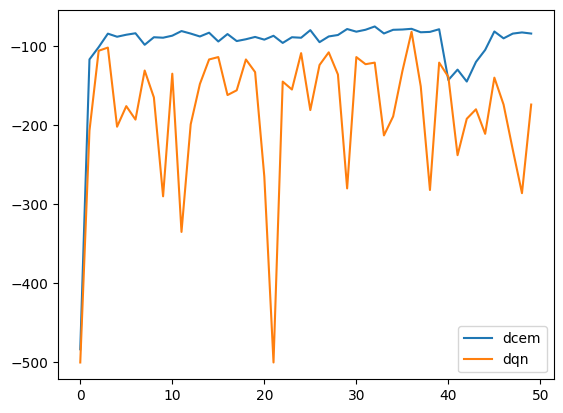

In [31]:
best_dqn = np.argmax(np.max(dqn_result, axis=1))
best_dcem = np.argmax(np.max(dcem_result, axis=1))

print(best_dqn)
print(best_dcem)
plt.plot(dcem_result[best_dcem], label='dcem')
plt.plot(dqn_result[best_dqn], label='dqn')
plt.legend()